# Classification Predict: Climate Change
### *Eugeniya Kharatyan*
### *19 October 2020*

In [62]:
## Loading Packages ##
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import nltk
from nltk.corpus import stopwords
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [10]:
stopwords_eng = stopwords.words('english')

In [4]:
## Assign Datasets ##
df_train = pd.read_csv('../input/climate-change-edsa2020-21/train.csv')
df_test = pd.read_csv('../input/climate-change-edsa2020-21/test.csv')
df_train.head(5)

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


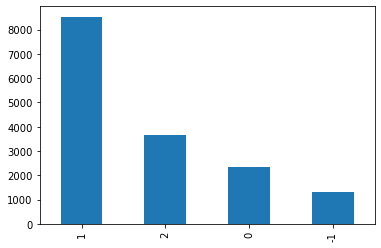

In [11]:
df_train['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [13]:
## Data Preprocessing ##
df_train['message'] = df_train['message'].str.lower()
df_test['message'] = df_test['message'].str.lower()

def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])
df_train['message'] = df_train['message'].apply(remove_punctuation)
df_test['message'] = df_test['message'].apply(remove_punctuation)

df_train.head(5)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesnt think carbon dio...,625221
1,1,its not like we lack evidence of anthropogenic...,126103
2,2,rt rawstory researchers say we have three year...,698562
3,1,todayinmaker wired 2016 was a pivotal year in...,573736
4,1,rt soynoviodetodas its 2016 and a racist sexis...,466954


In [ ]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_train['message'] = df_train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)
df_test['message'] = df_test['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [39]:
vect = CountVectorizer(stop_words='english', min_df= .01)
X_train = vect.fit_transform(df_train['message'].copy())
X_test = vect.transform(df_test['message'].copy())

y_train = df_train['sentiment'].copy()

In [28]:
## Fitting an SVC ##
parameters = {'kernel':('linear', 'rbf')}
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)

clf.best_params_

{'kernel': 'rbf'}

In [31]:
parameters = {'kernel': ['rbf'], 'C': (0.25,1.0)}
svm = SVC()
clf = GridSearchCV(svm, parameters)
clf.fit(X_train,y_train)

clf.best_params_

{'C': 1.0, 'kernel': 'rbf'}

In [32]:
svc = SVC(kernel = 'rbf', C = 1)
svc.fit(X_train, y_train)
y_hat_train = svc.predict(X_train)

print("\n\nClassification Report:\n\n",classification_report(y_train, y_hat_train))



Classification Report:

               precision    recall  f1-score   support

          -1       0.69      0.13      0.21      1296
           0       0.52      0.29      0.38      2353
           1       0.65      0.90      0.75      8530
           2       0.68      0.45      0.54      3640

    accuracy                           0.64     15819
   macro avg       0.63      0.44      0.47     15819
weighted avg       0.64      0.64      0.60     15819



In [44]:
y_hat_test_SVC = svc.predict(X_test)
get_id = df_test['tweetid'].values
df_out_SVC = pd.DataFrame({'sentiment' : y_hat_test_SVC, 'tweetid' : get_id})
df_out_SVC.head()

,sentiment,tweetid
0,2,169760
1,1,35326
2,1,224985
3,1,476263
4,0,872928


In [45]:
df_out_SVC.to_csv('submission_Eugeniya_Kharatyan.csv',index=False)

In [52]:
## Fitting Multiple Models ##
names = ['Logistic Regression', 'Nearest Neighbors','RBF SVM',
         'Decision Tree', 'Random Forest',  'AdaBoost']
classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier()
]

results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_train)

    f1        = metrics.f1_score(y_train, y_pred, average='macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_train, y_pred)

    results.append([name, f1, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'F1 Train', 'Train Time'])
results.set_index('Classifier', inplace= True)
results.sort_values('F1 Train', ascending=False)

Fitting Logistic Regression model...
Fitting Nearest Neighbors model...
Fitting RBF SVM model...
Fitting Decision Tree model...
Fitting Random Forest model...
Fitting AdaBoost model...


,F1 Train,Train Time
Classifier,,
Nearest Neighbors,0.516040,0.001616
RBF SVM,0.470841,18.509128
Logistic Regression,0.399262,0.826800
AdaBoost,0.396890,0.606132
Decision Tree,0.271072,0.019860
Random Forest,0.178438,0.052372


In [54]:
## Fitting KNN Model ##
parameters = {'n_neighbors': (5, 15, 20, 50), 'weights' : ['distance']}
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters)
clf.fit(X_train,y_train)

clf.best_params_

{'n_neighbors': 20, 'weights': 'distance'}

In [55]:
knn = KNeighborsClassifier(n_neighbors=20, weights='distance')
knn.fit(X_train, y_train)
y_hat_train = knn.predict(X_train)

print("\n\nClassification Report:\n\n",classification_report(y_train, y_hat_train))



Classification Report:

               precision    recall  f1-score   support

          -1       0.77      0.52      0.62      1296
           0       0.66      0.54      0.60      2353
           1       0.73      0.90      0.81      8530
           2       0.80      0.55      0.65      3640

    accuracy                           0.74     15819
   macro avg       0.74      0.63      0.67     15819
weighted avg       0.74      0.74      0.73     15819



In [58]:
y_hat_test_KNN = knn.predict(X_test)
get_id = df_test['tweetid'].values
df_out_KNN = pd.DataFrame({'sentiment' : y_hat_test_KNN, 'tweetid' : get_id})
df_out_KNN.head(5)

,sentiment,tweetid
0,2,169760
1,1,35326
2,1,224985
3,1,476263
4,0,872928


In [60]:
df_out_KNN.to_csv('submission_Eugeniya_Kharatyan.csv',index=False)

In [64]:
## Using Pipeline from Section 5 ##
X_train = df_train['message'].copy()
X_test = df_test['message'].copy()

clf = Pipeline([('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])
clf.fit(X_train, y_train)
y_hat_train = clf.predict(X_train)

print("\n\nClassification Report:\n\n",classification_report(y_train, y_hat_train))



Classification Report:

               precision    recall  f1-score   support

          -1       1.00      0.98      0.99      1296
           0       1.00      0.97      0.98      2353
           1       0.99      1.00      0.99      8530
           2       0.99      0.99      0.99      3640

    accuracy                           0.99     15819
   macro avg       0.99      0.98      0.99     15819
weighted avg       0.99      0.99      0.99     15819



In [65]:
y_hat_test_Pipe = clf.predict(X_test)
get_id = df_test['tweetid'].values
df_out_Pipe = pd.DataFrame({'sentiment' : y_hat_test_Pipe, 'tweetid' : get_id})
df_out_Pipe.head(5)

,sentiment,tweetid
0,1,169760
1,1,35326
2,1,224985
3,1,476263
4,0,872928


In [67]:
df_out_Pipe.to_csv('submission_Eugeniya_Kharatyan.csv',index=False)